# Preprocessing House Prices - Advanced Regression Techniques
### Authors: 
* Huỳnh Anh Nhựt
* Nguyễn Tiến Minh

### Import thư viện

In [201]:
import pandas as pd
import numpy as np
import scipy.stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')


In [202]:
train_df.shape

(1460, 81)

## Preprocessing

### Remove Outliers

In [203]:
# # train_clean = train_df.copy()
# # outlier_cols = ['GrLivArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF']
# # for col in outlier_cols:
# #     if col in train_clean.columns:
# #         Q1 = train_clean[col].quantile(0.25)
# #         Q3 = train_clean[col].quantile(0.75)
# #         IQR = Q3 - Q1
# #         lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
# #         train_clean = train_clean[(train_clean[col] >= lower) & (train_clean[col] <= upper)]
    
# # print(f"Loại outlier: {len(train_df) - len(train_clean)} mẫu outlier")

# # train_df = train_clean.reset_index(drop=True)
# # train_df.shape

train_df.drop(train_df[(train_df['SalePrice'] <= 300000) & (train_df['GrLivArea'] >= 4000)].index, inplace=True)

train_df.shape

(1458, 81)

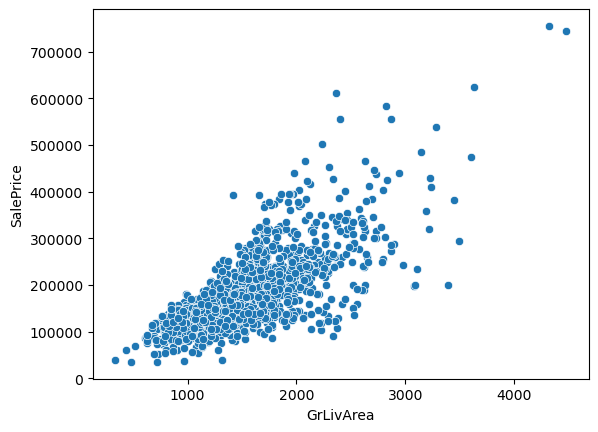

In [204]:
sns.scatterplot(data=train_df, x='GrLivArea', y='SalePrice')
plt.show()

### Merge the datasets

In [205]:
df = pd.concat([train_df, test_df], axis=0, sort=False)

df.shape

(2917, 81)

### Fill missing value

In [206]:
def missing_values(df):
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
    return missing_values
print(missing_values(df))

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
MasVnrType      1766
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
Utilities          2
KitchenQual        1
TotalBsmtSF        1
BsmtUnfSF          1
GarageCars         1
GarageArea         1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
Electrical         1
dtype: int64


In [207]:
print(len(missing_values(df)))

35


In [208]:
none_cols = [
    'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'MasVnrType', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'MasVnrType', 'PoolQC'
    ]
for col in none_cols:
    df[col] = df[col].fillna('None')

df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
df['LotFrontage'] = df['LotFrontage'].fillna(0)

cols = [
     'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd',
    'SaleType', 'MSZoning', 'Functional', 'Utilities',
     'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea',
        'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF'
]
for col in cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print(missing_values(df))

SalePrice    1459
dtype: int64


### Features engineering

In [209]:
# Các tạo các đặc trưng mới về tuổi của ngôi nhà

df['HouseAge'] = df['YrSold'] - df['YearBuilt']
df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
df['GarageAge'] = df['YrSold'] - df['GarageYrBlt']

df.drop(['YrSold', 'MoSold'], inplace=True, axis=1)


In [210]:
# Tạo các đặc trưng tổng diện tích sử dụng
df['BsmtFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2']

df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

df.drop(['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2'], axis=1, inplace=True)

In [211]:
# Các đặc trưng liên quan đến phòng tắm
df['TotalBath'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                   df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

df.drop(['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], axis=1, inplace=True)

In [212]:
# Các đặc trưng liên quan đến Garage
df['GarageAreaPerCar'] = df['GarageArea'] / df['GarageCars']

df['GarageAreaPerCar'] = df['GarageAreaPerCar'].fillna(0)


In [213]:
# Các đặc trưng nhị phân thể hiện sự tồn tại của các tiện ích
df['HasPool'] = (df['PoolArea'] > 0).astype(int)
df['HasGarage'] = (df['GarageArea'] > 0).astype(int)
df['HasFireplace'] = (df['Fireplaces'] > 0).astype(int)
df['HasBsmt'] = (df['TotalBsmtSF'] > 0).astype(int)

df.drop(['GarageArea', 'GarageCars'], axis=1, inplace=True)

### Data tranformation

In [214]:
numerical_cols = [ cname for cname in df.columns if df[cname].dtypes!= 'object' and cname != 'SalePrice' ]

skew_df = pd.DataFrame(numerical_cols, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(df[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].abs()
skew_df['Skew'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)

skew_df

,Feature,Skew,Absolute Skew
0,Id,False,0.000867
1,MSSubClass,True,1.375131
2,LotFrontage,False,0.127474
3,LotArea,True,13.109495
4,OverallQual,False,0.189591
5,OverallCond,True,0.569314
6,YearBuilt,True,0.599194
7,YearRemodAdd,False,0.450134
8,MasVnrArea,True,2.621719
9,BsmtUnfSF,True,0.919688


In [215]:
for col in skew_df[skew_df['Skew'] == True]['Feature']:
    df[col] = np.log1p(df[col])

c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Encoding feature

In [216]:
numerical_cols = df.select_dtypes(exclude=['object']).columns

numerical_cols

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtUnfSF',
       'TotalBsmtSF', 'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice', 'HouseAge',
       'RemodAge', 'GarageAge', 'BsmtFinSF', 'TotalSF', 'TotalBath',
       'GarageAreaPerCar', 'HasPool', 'HasGarage', 'HasFireplace', 'HasBsmt'],
      dtype='object')

In [217]:
categorical_cols = df.select_dtypes(include=['object']).columns


df_categorical = df[categorical_cols].copy()

In [218]:
print(f"Số dòng: {df.shape[0]}, Số cột phân loại: {df.shape[1]} trước mã hóa")

Số dòng: 2917, Số cột phân loại: 80 trước mã hóa


In [219]:
ordinal_1 = ['ExterQual' , 'ExterCond' , 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

for col in ordinal_1:
    if 'None' in df[col].value_counts().index:
        df[col] = df[col].map({'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}).astype(int)
    else:
        df[col] = df[col].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}).astype(int)

In [220]:
ordinal_2 = ['LotShape','LandContour','Utilities' ,'CentralAir','PavedDrive', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish', 'Fence', 'Heating', 'LandSlope']

df['LotShape'] = df['LotShape'].map({'None':0, 'IR3':1, 'IR2':2, 'IR1':3, 'Reg':4}).astype(int)
df['LandContour'] = df['LandContour'].map({"None":0, "Low":1, "HLS":2, "Bnk":3, "Lvl":4}).astype(int)
df['Utilities'] = df['Utilities'].map({"None":0, "ELO":1, "NoSeWa":2, "NoSewr":3, "AllPub":4}).astype(int)
df['CentralAir'] = df['CentralAir'].map({'None':0, 'N':1 ,'Y':2,}).astype(int)
df['PavedDrive'] = df['PavedDrive'].map({'None':0, 'N':1,'P':2,'Y':3}).astype(int)
df['BsmtExposure'] = df['BsmtExposure'].map({'None':0, 'No':1,'Mn':2,'Av':3,'Gd':4}).astype(int)
df['BsmtFinType1'] = df['BsmtFinType1'].map({'None':0, 'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6}).astype(int)
df['BsmtFinType2'] = df['BsmtFinType2'].map({'None':0, 'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6}).astype(int)
df['Functional'] = df['Functional'].map({'None':0, 'Sal':1,'Sev':2,'Maj2':3,'Maj1':4,'Mod':5,'Min2':6,'Min1':7,'Typ':8}).astype(int)
df['GarageFinish'] = df['GarageFinish'].map({'None':0, 'Unf':1,'RFn':2,'Fin':3}).astype(int)
df['Fence'] = df['Fence'].map({'None':0, 'MnWw':1,'GdWo':2,'MnPrv':3,'GdPrv':4}).astype(int)
df['Heating'] = df['Heating'].map({'None':0, 'Floor':1,'Wall':2,'OthW':3,'GasA':4,'GasW':5,'Grav':6,'Water':7,'Steam':8}).astype(int)
df['LandSlope'] = df['LandSlope'].map({'None':0, 'Sev':1,'Mod':2,'Gtl':3}).astype(int)


In [221]:
# tách các cột non-ordinal còn lại từ df_categorical

df_categorical = df_categorical.drop(columns = ordinal_1) 
df_categorical = df_categorical.drop(columns = ordinal_2) 

ohe = df_categorical.columns.tolist()

df_encoded = pd.get_dummies(df_categorical, columns=ohe, drop_first=True).astype(int)

df = pd.concat([df.drop(columns = ohe), df_encoded], axis=1)


In [222]:
print(f"Sô dòng: {df.shape[0]}, Số cột phân loại: {df.shape[1]} sau mã hóa")

Sô dòng: 2917, Số cột phân loại: 196 sau mã hóa


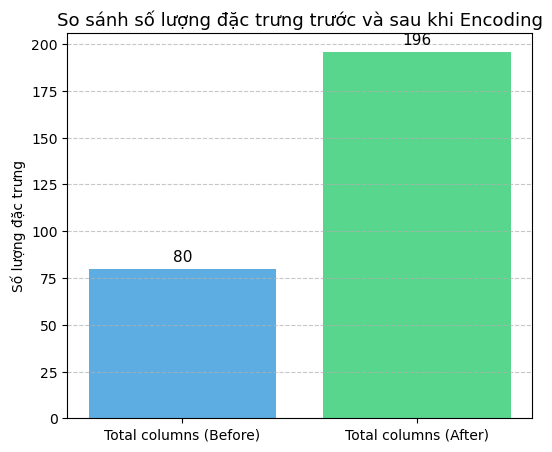

In [223]:
import matplotlib.pyplot as plt

# Số lượng đặc trưng trước và sau khi mã hóa
before_categorical = len(ordinal_1 + ordinal_2) + len(ohe) + len(df[numerical_cols].columns)  # tổng số cột phân loại ban đầu
after_total = df.shape[1]                           # tổng số cột sau khi encode

# Dữ liệu vẽ
categories = ['Total columns (Before)', 'Total columns (After)']
values = [before_categorical, after_total]

# Vẽ biểu đồ
plt.figure(figsize=(6, 5))
bars = plt.bar(categories, values, color=['#5DADE2', '#58D68D'])

# Ghi giá trị lên đầu cột
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
             f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=11)

plt.title('So sánh số lượng đặc trưng trước và sau khi Encoding', fontsize=13)
plt.ylabel('Số lượng đặc trưng')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [224]:
missing_values(df)

SalePrice    1459
GarageAge       1
dtype: int64

### Split train, test data

In [225]:
df_train = df.iloc[:train_df.shape[0]]

df_test = df.iloc[train_df.shape[0]:]

df_train.drop(['Id'], inplace=True, axis=1)
df_test.drop(['Id', 'SalePrice'], inplace=True, axis=1)

C:\Users\MSI VN\AppData\Local\Temp\ipykernel_12352\1989219299.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(['Id'], inplace=True, axis=1)
C:\Users\MSI VN\AppData\Local\Temp\ipykernel_12352\1989219299.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(['Id', 'SalePrice'], inplace=True, axis=1)


### Encode SalePrice

In [226]:
log_target = np.log1p(df_train['SalePrice'])
df_train.drop('SalePrice', axis=1, inplace=True)

C:\Users\MSI VN\AppData\Local\Temp\ipykernel_12352\556502089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop('SalePrice', axis=1, inplace=True)


## train model

In [227]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error



In [228]:
X = df_train.copy()
y = log_target.copy()  # log ngay

X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

# 4. Các model
models = {
    'Ridge'        : Ridge(alpha=1.0),
    'RF'           : RandomForestRegressor(n_estimators=200, random_state=42),
    'GBR'          : GradientBoostingRegressor(n_estimators=200, random_state=42),
    'XGBoost'      : XGBRegressor(n_estimators=300, random_state=42, verbosity=0),
    'LightGBM'     : LGBMRegressor(n_estimators=300, random_state=42, verbose=-1),
    'CatBoost'     : CatBoostRegressor(n_estimators=300, random_state=42, verbose=0),
}

# 5. Đánh giá
results = []
print("\n=== Đánh giá nhanh ===")
for name, model in models.items():
    model.fit(X_tr, y_tr)
    pred = model.predict(X_val)               # ← X_val, không phải y_val
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    results.append({'Model': name, 'RMSE': rmse})
    print(f"{name:12} → {rmse:.5f}")

res_df = pd.DataFrame(results).sort_values('RMSE').reset_index(drop=True)
print("\n=== TOP 3 ===")
res_df


=== Đánh giá nhanh ===
Ridge        → 0.11678


KeyboardInterrupt: 

## Hyperparamter Tuning

In [ ]:
def objective(trial):
    model_name = trial.suggest_categorical('model', ['Ridge', 'CatBoost', 'GBR'])
    
    if model_name == 'Ridge':
        params = {
            'alpha': trial.suggest_float('alpha', 0.01, 100, log=True),
            'solver': trial.suggest_categorical('solver', ['svd', 'cholesky', 'lsqr']),
            'max_iter': 10000
        }
        model = Ridge(**params)
    
    elif model_name == 'CatBoost':
        params = {
            'iterations'    : trial.suggest_int('iterations', 500, 1500),
            'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'depth'         : trial.suggest_int('depth', 6, 10),
            'l2_leaf_reg'   : trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
            'border_count'  : trial.suggest_int('border_count', 128, 254),
            'random_state'  : 42,
            'verbose'       : 0
        }
        model = CatBoostRegressor(**params)
    
    # else:  # RF
    #     params = {
    #         'n_estimators'      : trial.suggest_int('n_estimators', 500, 1500),
    #         'max_depth'         : trial.suggest_int('max_depth', 10, 30),
    #         'min_samples_split' : trial.suggest_int('min_samples_split', 2, 10),
    #         'min_samples_leaf'  : trial.suggest_int('min_samples_leaf', 1, 5),
    #         'max_features'      : trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.8]),
    #         'random_state'      : 42
    #     }
    #     model = RandomForestRegressor(**params)
    else: # GRB
        params = {
            'n_estimators'      : trial.suggest_int('n_estimators', 500, 1500),
            'learning_rate'     : trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'max_depth'         : trial.suggest_int('max_depth', 3, 10),
            'subsample'         : trial.suggest_float('subsample', 0.6, 1.0),
            'min_samples_split' : trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf'  : trial.suggest_int('min_samples_leaf', 1, 5),
            'max_features'      : trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.8]),
            'random_state'      : 42
        }
        model = GradientBoostingRegressor(**params)

    # 5-fold CV
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmses = []
    for tr_idx, val_idx in kf.split(X):
        model.fit(X.iloc[tr_idx], y.iloc[tr_idx])
        pred = model.predict(X.iloc[val_idx])
        rmses.append(np.sqrt(mean_squared_error(y.iloc[val_idx], pred)))
    return np.mean(rmses)

# CHẠY
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print(study.best_params)
print(f"Best RMSE: {study.best_value:.5f}")


[I 2025-11-13 12:05:02,630] A new study created in memory with name: no-name-ecfb4fef-88b1-4011-90c9-160bb216ada3
[I 2025-11-13 12:05:13,107] Trial 0 finished with value: 0.12253538139399908 and parameters: {'model': 'GBR', 'n_estimators': 1210, 'learning_rate': 0.01922973517474873, 'max_depth': 10, 'subsample': 0.900156158624494, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.12253538139399908.
[I 2025-11-13 12:05:27,298] Trial 1 finished with value: 0.11874637438666795 and parameters: {'model': 'CatBoost', 'iterations': 661, 'learning_rate': 0.0668888805717059, 'depth': 8, 'l2_leaf_reg': 5.193717456809382, 'border_count': 137}. Best is trial 1 with value: 0.11874637438666795.
[I 2025-11-13 12:05:27,336] Trial 2 finished with value: 0.12105745214133538 and parameters: {'model': 'Ridge', 'alpha': 24.144331246253994, 'solver': 'cholesky'}. Best is trial 1 with value: 0.11874637438666795.
[I 2025-11-13 12:05:37,191] Trial 3 finished 

{'model': 'CatBoost', 'iterations': 1468, 'learning_rate': 0.057687069783469797, 'depth': 7, 'l2_leaf_reg': 3.933836591060142, 'border_count': 180}
Best RMSE: 0.11616


In [ ]:
# Lấy toàn bộ kết quả từ Optuna
results_df = study.trials_dataframe()

# Tạo dict chứa best params cho từng model
best_params_per_model = {}

# Duyệt qua từng model name có trong trials
for model_name in results_df['params_model'].unique():
    # Lọc trials của model đó
    sub_df = results_df[results_df['params_model'] == model_name]
    
    # Lấy trial có giá trị 'value' (RMSE) nhỏ nhất
    best_trial = sub_df.loc[sub_df['value'].idxmin()]
    
    # Lấy các tham số thuộc model đó
    params = {
        col.replace('params_', ''): best_trial[col]
        for col in results_df.columns
        if col.startswith('params_')
    }
    
    # Xóa param không thuộc model này
    valid_params = {}
    if model_name == 'Ridge':
        allow = ['alpha', 'solver', 'max_iter']
    elif model_name == 'CatBoost':
        allow = ['iterations', 'learning_rate', 'depth', 'l2_leaf_reg', 'border_count', 'random_state', 'verbose']
    elif model_name == 'GBR':
        allow = ['n_estimators', 'learning_rate', 'max_depth', 'subsample', 'min_samples_split', 'min_samples_leaf', 'max_features', 'random_state']
    else:
        allow = []
    
    for k in params:
        if k in allow:
            val = params[k]
            # Ép kiểu cho các tham số cần là int
            if k in ['max_depth', 'n_estimators', 'min_samples_split', 'min_samples_leaf', 
                    'iterations', 'depth', 'border_count']:
                val = int(val)
            valid_params[k] = val

    
    best_params_per_model[model_name] = valid_params

# Hiển thị 3 bộ tham số tốt nhất
from pprint import pprint
pprint(best_params_per_model)


{'CatBoost': {'border_count': 180,
              'depth': 7,
              'iterations': 1468,
              'l2_leaf_reg': 3.933836591060142,
              'learning_rate': 0.057687069783469797},
 'GBR': {'learning_rate': 0.01588483370133864,
         'max_depth': 7,
         'max_features': 'log2',
         'min_samples_leaf': 3,
         'min_samples_split': 2,
         'n_estimators': 1087,
         'subsample': 0.7927244770511056},
 'Ridge': {'alpha': 1.1258572779542464, 'solver': 'lsqr'}}


In [ ]:
ridge_best = Ridge(**best_params_per_model.get('Ridge', {}))
cat_best   = CatBoostRegressor(**best_params_per_model.get('CatBoost', {}), verbose=0)
gbr_best   = GradientBoostingRegressor(**best_params_per_model.get('GBR', {}))


# 3. Huấn luyện trên toàn bộ dữ liệu
print("\nHuấn luyện model trên toàn bộ train...")
ridge_best.fit(X, y)
cat_best.fit(X, y)
gbr_best.fit(X, y)

# 4. Dự đoán trên test
print("Dự đoán trên test set...")
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test.fillna(0, inplace=True)
ridge_pred = np.expm1(ridge_best.predict(df_test))
cat_pred   = np.expm1(cat_best.predict(df_test))
gbr_pred   = np.expm1(gbr_best.predict(df_test))

final_preds = gbr_pred

# 5. Tạo submission
submission = pd.DataFrame({
    'Id': test_df['Id'].astype(int),
    'SalePrice': final_preds
})

# 6. Lưu file
submission.to_csv('./submission/submission_gbr.csv', index=False)

print(f"\nSUBMISSION ĐÃ SẴN SÀNG!")
print(f"   Số mẫu: {len(submission)}")
print(f"   Giá min: {final_preds.min():.0f}, max: {final_preds.max():.0f}")


Huấn luyện model trên toàn bộ train...
Dự đoán trên test set...

SUBMISSION ĐÃ SẴN SÀNG!
   Số mẫu: 1459
   Giá min: 49269, max: 612614


C:\Users\MSI VN\AppData\Local\Temp\ipykernel_12352\4130864569.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\MSI VN\AppData\Local\Temp\ipykernel_12352\4130864569.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.fillna(0, inplace=True)


## Experirment

1. 15:54, 11/11/2025 lần test đầu tiên,ridge là cao nhất, kaggle 0.13422
2. 16:07, 11/11/2025 thêm 2 feature 'TotalPorchSF', 'LivLotRatio', rigde là model tốt nhất, kaggle 0.13439
3. 16:25, 11/11/2025 log tranform cho 2 feature mới, drop các cột dùng để tạo feature, kaggle tăng 0.14 => ko nên thêm 2 ffeature
4. 10:09, 11/11/2025 preprocess data cách khác, kaggle giảm còn 0.12175
5. 10:47, 11/11/2025 weighted blending, kaggle giảm còn 0.11855
6. 7:00, 12/11/2025 remove outlier tăng RMSE
7. 8:00, 12/11/2025 0.5 ridge, 0.5 catboost , kaggle 0.11802
8. 8:13, 12/11/2025 0.6 catboost, 0.4 ridge, kaggle 0.117 => weight của catboost càng lớn thì RMSE sẽ giảm
9. 8:18, 12/11/2025 0.7 catboost, 0.3 rigde là weight tối ưu nhất với 0.11723
10. 19:31, 12/11/2025 0.7 catboost, 0.3 rigde + remove 2 outlier, kaggle 0.11988


